importing needed libraries

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

## preprocessing the dataset

In [3]:
df = pd.read_csv('TeePublic_review.csv', encoding='ISO-8859-1')
df.head()

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4


<Axes: >

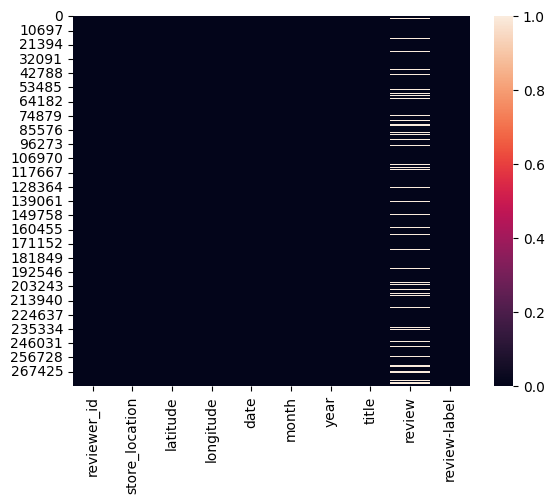

In [4]:
sns.heatmap(df.isnull())

In [4]:
df.dropna(inplace=True)

<Axes: xlabel='review-label', ylabel='count'>

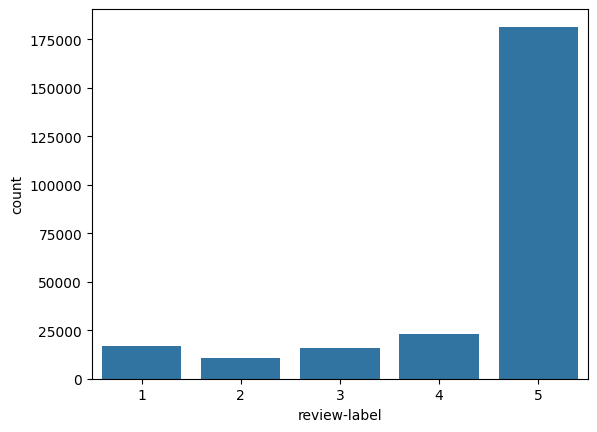

In [38]:
sns.countplot(x='review-label', data=df)

In [5]:
min_count = df['review-label'].value_counts().min()
balanced_df = pd.DataFrame()

for i in range(1,6):
    balanced_df = pd.concat([balanced_df, df[df['review-label'] == i].sample(n=min_count, random_state=42)], axis=0)



<Axes: xlabel='review-label', ylabel='count'>

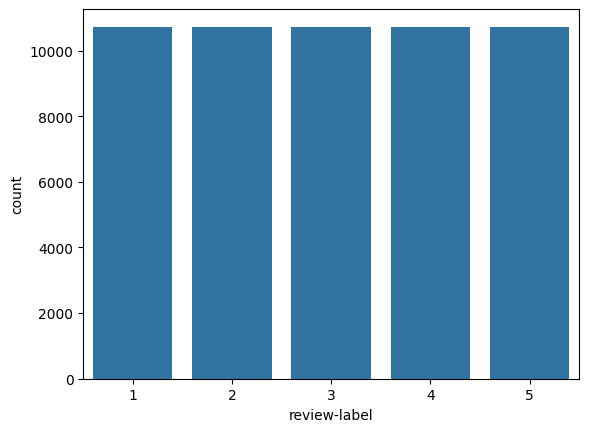

In [40]:
sns.countplot(x='review-label', data=balanced_df)

stemming the text

eg.: saying ====> say

In [6]:
neg_words =['not','don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",  'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", "won't", 'wouldn', "wouldn't"]
english_stopwords = [x for x in stopwords.words('english') if x not in neg_words]
len(english_stopwords)

142

In [7]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [porterstemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [8]:
porterstemmer = PorterStemmer()

In [9]:
balanced_df['review'] = balanced_df['review'].apply(stemming)

In [15]:
balanced_df.dropna(inplace=True)

In [16]:
#save the balanced preprocessed dataset
balanced_df.to_csv('balanced_df.csv', index=False)

Using the review column as  input and the review-label as the target output

In [7]:
balanced_df = pd.read_csv('balanced_df.csv')

In [12]:
balanced_df.dropna(inplace=True)

In [13]:
X  = balanced_df['review']
Y = balanced_df['review-label']

vecotrize the input review

In [14]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

cross-validation

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

Using logistic regression to predict the label

In [134]:
logistic_model = LogisticRegression()

In [135]:
logistic_model.fit(x_train, y_train)

c:\Users\OWNER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [136]:
train_pred = logistic_model.predict(x_train)
test_pred =logistic_model.predict(x_test)

results of the logistic model

In [31]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           1       0.78      0.85      0.82      7509
           2       0.79      0.74      0.77      7510
           3       0.79      0.75      0.77      7509
           4       0.82      0.76      0.79      7510
           5       0.84      0.93      0.88      7508

    accuracy                           0.81     37546
   macro avg       0.81      0.81      0.81     37546
weighted avg       0.81      0.81      0.81     37546



In [32]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           1       0.58      0.64      0.61      3219
           2       0.43      0.40      0.42      3218
           3       0.44      0.40      0.42      3219
           4       0.56      0.52      0.54      3218
           5       0.73      0.83      0.78      3218

    accuracy                           0.56     16092
   macro avg       0.55      0.56      0.55     16092
weighted avg       0.55      0.56      0.55     16092



<Axes: >

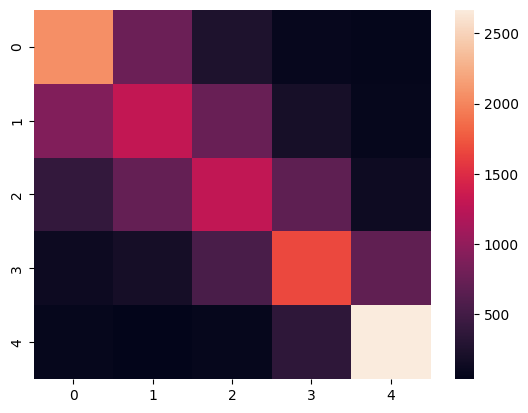

In [33]:
sns.heatmap(confusion_matrix(y_test, test_pred) )

In [34]:
misclassified_indices = (test_pred != y_test)

In [35]:
misclassified_samples = pd.DataFrame({
    'Actual': y_test[misclassified_indices],
    'Predicted': test_pred[misclassified_indices],

})

In [36]:
misclassified_samples.head(20)

,Actual,Predicted
17748,2,1
17912,2,1
47534,5,3
27756,3,2
39298,4,2
50126,5,4
17806,2,1
11398,2,4
49343,5,4
41575,4,5


In [143]:
def take_output(input_text):
    text = stemming(input_text)
    vector = vectorizer.transform([text])
    prediction = logistic_model.predict(vector)
    print(prediction)

In [26]:
from sklearn.svm import SVC

In [29]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[
    ('svc',SVC(probability=True)),
    ('lr', LogisticRegression(max_iter=500)), 
    ('xgb', XGBClassifier())], voting='soft')

model.fit(x_train, y_train)


VotingClassifier(estimators=[('svc', SVC(probability=True)),
                             ('lr', LogisticRegression(max_iter=500)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_pol...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [30]:
test_pred = model.predict(x_test)
train_pred = model.predict(x_train)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LogisticRegression(), x_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {scores.mean()}")


Cross-Validation Accuracy: 0.5369946654338806
